# Por dentro da caixa-preta: uma abordagem prática de IA e NLP

Esse colab foi elaborado para o workshop [Por trás da caixa-preta: uma abordagem prática de IA e NLP](https://escoladedados.org/coda/coda2023/por-dentro-da-caixa-preta-uma-abordagem-pratica-de-ia-e-nlp/) do Coda.Br 2023.

Vamos abordar aqui alguns conceitos fundamentais sobre Aprendizado de Máquina, Redes Neurais e Processamento de Linguagem Natural. O principal exemplo de aplicação será a classificação de ementas da ALESP usando TF-IDF e MLP.



Instalação dos pacotes:

In [ ]:
!pip install unidecode

import pandas as pd
import nltk
import torch
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from copy import deepcopy

from nltk import word_tokenize, download
from nltk.stem import WordNetLemmatizer

#from sklearn.datasets import load_iris
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('punkt')
nltk.download('wordnet')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Dados

In [ ]:
# subindo os dados
# proposituras são as ementas
# proposituras parecer tem a coluna para saber se foi classsificado com o parecer favorável ou contrário

df_1 = pd.read_xml('/content/proposituras.xml')
df_2 = pd.read_xml('/content/propositura_parecer.xml')

In [ ]:
# juntando a ementa e seu parecer
# ambas tem a coluna 'IdDocumento'
df = df_1.merge(df_2)

In [ ]:
# filtrando apenas as informações necessárias

df = df[['AnoLegislativo', 'Ementa', 'TipoParecer', 'IdDocumento']]

In [ ]:
# eliminando as ementas duplicadas

# muitos casos tinham ementas iguais e que, uma hora tinham sido consideradas
# contrárias e outra hora favorável. Por isso é excluída ambas

df= df.drop_duplicates(subset='Ementa', keep=False )

In [ ]:
# selecionando apenas quem tem aprecer favorável ou contrário

df_contrario = df.query('TipoParecer == "contrário"')
df_favoravel = df.query('TipoParecer == "favorável"')

In [ ]:
# criando um dataframe
df_provisorio_fav = pd.DataFrame()

# O número de itens favoráveis é muito maior.
# Selecionando o mesmo número de favoráveis e não favoráveis por ano.
# exemplo: no ano de 2011 existem 44 favoráveis e 44 contrários


for index_ano, num_item in df_contrario.drop_duplicates(subset='Ementa')['AnoLegislativo'].value_counts().iteritems():
  if len(df_favoravel.query(f'AnoLegislativo == {index_ano}')) >= num_item:
    df_parte = df_favoravel.query(f'AnoLegislativo == {index_ano}').sample(num_item)
  else:
    df_parte = df_favoravel.query(f'AnoLegislativo == {index_ano}')
  df_provisorio_fav = pd.concat([df_provisorio_fav, df_parte])

<ipython-input-104-1c1c8600fedc>:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index_ano, num_item in df_contrario.drop_duplicates(subset='Ementa')['AnoLegislativo'].value_counts().iteritems():


In [ ]:
# juntando os contrários e os favoráveis

df = pd.concat([df_provisorio, df_contrario])

In [ ]:
# excluindo uma linha que tinha a mais no contrário
df.drop(axis=0, index=82957, inplace=True)

In [ ]:
# mudando o nome da coluna para como foi usado anteriormente

df.rename(columns={'AnoLegislativo' : 'ano',
                         'Ementa' : 'ementa',
                         'TipoParecer' : 'classe',
                         'IdDocumento' : 'id_prop'}, inplace=True)

In [ ]:
df.to_csv('ementas_classe.csv', index=False)

In [ ]:
df['classe'].value_counts()

favorável    206
contrário    206
Name: classe, dtype: int64

In [ ]:
# visualizando os dados

df.head()

,ano,ementa,classe,id_prop
596516,2011,"Aplaude a Rádio Aparecida, fundada há sessenta...",favorável,1030208
581157,2011,"Declara de utilidade pública a ""Associação Lar...",favorável,1001354
597377,2011,"Declara de utilidade pública o ""Lions Clube Fr...",favorável,1044407
595474,2011,"Declara de utilidade pública a ""Associação Cul...",favorável,1061311
618195,2011,"Declara de utilidade pública o VICC - ""Voluntá...",favorável,1046129


## Perceptron: o neurônio artificial

Vamos começar investigando um modelo mais "simples". O Perceptron se baseia em um modelo simplificado do funcionamento de um neurônio humano, que recebe impulsos elétricos pelos dendritos, os processa no corpo celular e emite novos impulsos para outros neurônios através do axônio.

Um Perceptron simula esse comportamento recebendo como entrada um vetor de números reais. Cada valor do vetor é multiplicado por um "peso", também chamado de "parâmetro", de forma que cada valor da entrada contribui em quantidades diferentes para a resposta final. Esse processo simula o recebimento de impulsos no neurônio pelos dendritos.

A parte do corpo celular é feita somando todos os valores dos nossos "dendritos", combinando esse resultado em um numero único. Esses resultados são somados também a um valor estático, chamado **viés** ou *bias*.

Por fim, a soma é passada como entrada por uma **função de ativação**, que determina a "força" do impulso de saída a partir do valor calculado. Isso é feito pois é normal que o valor de saída de um Perceptron seja limitado entre 0 e 1.

Mas como são determinados os valores dos pesos? Eles são determinados através de um processo de **treinamento** ou **aprendizagem**, na qual o Perceptron recebe uma série de dados de entrada, que são avaliados com os pesos atuais e ajustados conforme o **erro** (*loss*) em relação ao valor correto.

### Teste

É hora de finalmente mensurarmos a qualidade do modelo que treinamos. Pelo gráfico acima, podemos ver que a época `14` teve bom desempenho na validação, obtendo um *score* médio de `0.8`, enquanto avançou bastante no treinamento.

> Embora épocas anteriores tenham obtido pontuações semelhantes, o modelo ainda não é capaz de generalizar muito bem, e pelos testes que fizemos, simplesmente nunca escolhe a classe `1` como resposta.

Vamos escolher esse como nosso modelo final, e testá-lo com outro conjunto de entradas que ele nunca viu antes. Os resultados da classificação podem ser obtidos com o método `predict`.

Por fim, pedimos ao Scikit-learn que gere um relatório dos resultados obtidos com a função `classification_report`.

A principal métrica em que estamos interessados é a **acurácia** (*accuracy*), que indica quantas vezes o modelo acertou sua classificação dividido pela quantidade de entradas que foram classificadas. Pelo relatório, podemos ver que nosso modelo obteve uma acurácia de `0.87`, ou seja, acertou 87% das classificações que fez!

## NLP - Processamento de Linguagem Natural

*Natural Language Processing* (NLP) é o conjunto de técnicas de IA capazes de fazer inferências sobre texto criado por e para seres humanos, que em geral é mais complicado de ser processado por computadores.

Nesse exercício, vamos fazer a análise de proposituras da Assembleia Legislativa do Estado de São Paulo. A partir de um documento com o texto das ementas das mesmas, e o parecer de cada uma, vamos extrair um vetor numérico de características (um *embedding*) que pode ser classificado usando uma rede neural. Ou seja, vamos prever o parecer de uma propositura apenas pela sua ementa!

Primeiramente, vamos visualizar nossos dados:

In [ ]:
df[['ementa', 'classe']]

,ementa,classe
548585,"Declara de utilidade pública a ""Sociedade Unid...",favorável
605895,Apela para os Srs. Presidentes da Câmara dos D...,favorável
581531,"Declara de utilidade pública a ""Organização Nã...",favorável
612505,"Declara de utilidade pública a ""Casa de Apoio ...",favorável
582915,Apela para a Sra. Presidente da República para...,favorável
...,...,...
631651,Altera o § 1º do artigo 112 da Resolução nº 57...,contrário
632407,"Denomina ""Joseph Safra"" a Rodovia SP 160, que ...",contrário
632811,Assegura a gratuidade de tarifa no sistema de ...,contrário
632846,"Altera a Lei Complementar nº 1.291, de 22 de j...",contrário


Vamos também separar as ementas das classes, para terminarmos a etapa de pré-processamento.

In [ ]:
X_pre = df['ementa']
y_pre = df['classe']

Como o classificador precisa que as classes sejam números, vamos usar a classe `LabelEncoder` do Scikit-learn para transformar as nossas categorias em valores numéricos

In [ ]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y_pre)

### Embeddings

*Word embeddings* são os métodos usados para transformar palavras e frases em vetores numéricos. A ideia é que palavras com significados semelhantes dentro de determinado contexto devem gerar vetores próximos, enquanto palavras muito diferentes devem gerar vetores bastante distantes.

### TF-IDF

*Term frequency/Inverse document frequency* (TF-IDF) é uma técnica de extração de características de texto natural puramente estatísitica, que cria uma representação em vetores numéricos pelas frequências em que as palavras são utilizadas num texto.

No nosso exemplo, vamos usar a classe `WordNetLemmatizer` da bibioteca nltk e a classe `TfidfVectorizer` do Scikit-learn para obter representações vetorizadas das ementas da ALESP.

In [ ]:
lemmatizer = WordNetLemmatizer()
tfidf_vectorizer = TfidfVectorizer()

descriptions_lemmatized = [" ".join([lemmatizer.lemmatize(token.lower()) for token in word_tokenize(description)]) for description in X_pre.values ]
descriptions_representation_tfidf = tfidf_vectorizer.fit_transform(descriptions_lemmatized)

X = descriptions_representation_tfidf

Vamos ver como ficou o formato da nossa base de dados após o pré-processamento:

In [ ]:
for i in range(5):
  print(X.toarray()[i], y[i])

[0. 0. 0. ... 0. 0. 0.] 1
[0. 0. 0. ... 0. 0. 0.] 1
[0. 0. 0. ... 0. 0. 0.] 1
[0. 0. 0. ... 0. 0. 0.] 1
[0. 0. 0. ... 0. 0. 0.] 1


## MLP: uma Rede Neural

Até agora, vimos apenas como fazer classificações com apenas um neurônio artificial. No entanto, há um limite para o processamento que apenas um neurônio pode realizar. Por isso, cérebros são compostos por vários neurônios em contato uns com os outros, processando e reprocessando os impulsos uns dos outros.

Podemos replicar algo parecido usando um classificador conhecido como *Multi-layer Perceptron* (MLP). Aqui, a ideia é organizar vários perceptrons em camadas, de forma que cada uma possa processar um "aspecto" diferente do problema em sequência.

Vamos utilizar a classe `MLPClassifier` do Scikit-learn para invocar um MLP e ajustar seus parâmetros. A divisão da base será feita apenas em treinamento e teste pois agora deixaremos a biblioteca fazer a validação automaticamente usando o hiperparâmetro `early_stopping=True`.

In [ ]:
# Divida os dados em conjuntos de treinamento e teste (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.2,
  random_state=42
)

# Crie uma instância do MLPClassifier
mlp = MLPClassifier(
  early_stopping=True,
  activation='logistic',
  max_iter=500,
  random_state=42,
  verbose=True
)

# Treine no conjunto de treinamento
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.69326520
Validation score: 0.515152
Iteration 2, loss = 0.68986719
Validation score: 0.515152
Iteration 3, loss = 0.68575522
Validation score: 0.545455
Iteration 4, loss = 0.68265716
Validation score: 0.727273
Iteration 5, loss = 0.67924887
Validation score: 0.727273
Iteration 6, loss = 0.67584939
Validation score: 0.666667
Iteration 7, loss = 0.67247779
Validation score: 0.696970
Iteration 8, loss = 0.66911839
Validation score: 0.636364
Iteration 9, loss = 0.66569606
Validation score: 0.636364
Iteration 10, loss = 0.66228111
Validation score: 0.696970
Iteration 11, loss = 0.65896113
Validation score: 0.696970
Iteration 12, loss = 0.65558582
Validation score: 0.757576
Iteration 13, loss = 0.65177221
Validation score: 0.848485
Iteration 14, loss = 0.64809812
Validation score: 0.848485
Iteration 15, loss = 0.64456283
Validation score: 0.848485
Iteration 16, loss = 0.64093169
Validation score: 0.848485
Iteration 17, loss = 0.63715925
Validation score: 0.848485
Iterat

MLPClassifier(activation='logistic', early_stopping=True, max_iter=500,
              random_state=42, verbose=True)

Sinta-se à vontade para experimentar com os parâmetros da rede!

Uma vez que nosso modelo está treinado, podemos medir seu desempenho usando nosso conjunto de teste. Primeiramente, vamos gerar o conjunto de predições do nosso classificador, comparar com a resposta correta e medir a acurácia:

In [ ]:
# Avalie o desempenho do modelo com a melhor configuração no conjunto de teste
y_pred = mlp.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)

# print("Melhores hiperparâmetros encontrados:", melhores_parametros)
print("Acurácia do melhor modelo no conjunto de teste:", acuracia)

Acurácia do melhor modelo no conjunto de teste: 0.7710843373493976


> **DISCLAIMER:** Ao analisar a base de dados, percebemos que vários dados estavam repetidos. Ao retirar as repetições, a acurácia do modelo caiu drasticamente. No entanto, essa repetição não é necessariamente um problema, sendo na verdade uma aplicação acidental da técnica de [data augmentation](https://www.datacamp.com/tutorial/complete-guide-data-augmentation). Vale destacar, porém, que isso foi **acidental** e não houve nenhuma metodologia por trás dessa aplicação, e que alguns dos valores no conjunto de teste *também* ficaram repetidos, aumentando levemente a acurácia em 2%. Optamos por deixar a base assim para fins didáticos, e porque, no final das contas, funcionou.

Vamos analisar também a **matriz de confusão** do nosso teste. A matriz de confusão é uma tabela em que cada coluna corresponde aos valores previstos pela rede, enquanto cada linha corresponde à classe real dos itens. O valor em cada célula compara quantos dados de uma determinada classe X foram previstos como sendo da classe Y. A "diagonal principal" representa os valores previstos corretamente.

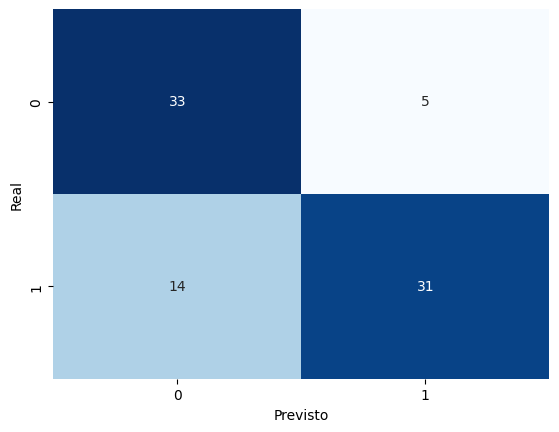

In [ ]:
matriz_confusao = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz_confusao, annot=True, cmap="Blues", fmt='d', cbar=False)

plt.xlabel('Previsto')
plt.ylabel('Real')

plt.show()

Por fim, podemos gerar um resumo das métricas do MLP. Esse resumo apresenta, além da acurácia geral, a **precisão**, o **recall** e o **F1-score** para cada classe do nosso problema. Cada uma dessas métricas corresponde a uma medida de erro diferente; você pode conferir o significado de cada uma [aqui](https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide).

In [ ]:
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.70      0.87      0.78        38
           1       0.86      0.69      0.77        45

    accuracy                           0.77        83
   macro avg       0.78      0.78      0.77        83
weighted avg       0.79      0.77      0.77        83



Podemos visualizar também como foi o desempenho do treinamento. Os parâmetros `loss_curve_` e `validation_scores_` mostram como o erro do treinamento e o *score* da validação foram melhorando ao longo das épocas. O ideal seria comparar apenas os erros do treino e da validação, mas como o Scikit-learn não exporta essa última métrica, podemos ter uma ideia de como a mesma se comporta pelo *score*:

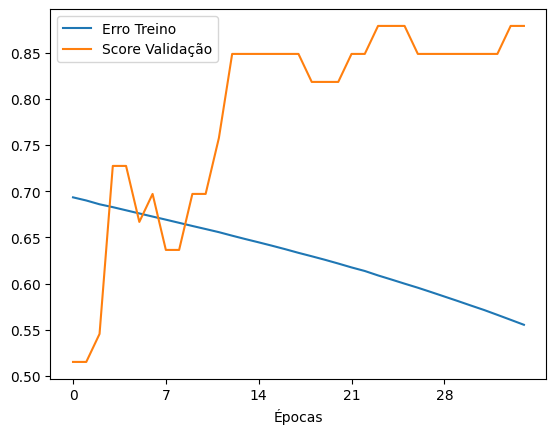

In [ ]:
plt.xlabel('Épocas')
plt.xticks(range(0, mlp.n_iter_, 7))
plt.plot(
  list(zip(mlp.loss_curve_, mlp.validation_scores_)),
  label=['Erro Treino', 'Score Validação']
)
plt.legend()
plt.show()

### Testando o classificador na prática

Vamos usar o método `predict` do nosso classificador para testar alguns valores reais de ementas, e quais as suas previsões. `0` representa um parecer contrário, enquanto `1` representa um parecer favorável.

In [ ]:
#texto1 = "Dispõe sobre a proibição da utilização de de scooter eletricas na calçada." # Y = 0 = Contra
texto1 = "Dispõe sobre a obrigatoriedade do Estado de manter escolas musicais nos municípios do mato grosso do sul." # Y = 1 = A favor

texto1_embeddings = tfidf_vectorizer.transform([texto1])

# Agora tente prever com o MLP
mlp.predict(texto1_embeddings)[0]

0

Podemos ver também a "probabilidade", ou *score*, do item pertencer a cada classe segundo o modelo:


In [ ]:
proba = mlp.predict_proba(texto1_embeddings)

print(f'Contra:  {(proba[0][0]*100):.2f}%')
print(f'A favor: {(proba[0][1]*100):.2f}%')

Contra:  53.55%
A favor: 46.45%


## BÔNUS: *Cross-validation* com `GridSearchCV`

Além do processo normal de validação dos parâmetros internos da rede, é possível validar os hiperparâmetros da mesma, como tamanho das camadas ocultas, função de ativação, entre outros; antes da fase de teste. Esse processo é conhecido como **validação cruzada** ou *cross-validation*, e facilita e automatiza o processo de ajuste da rede.

Durante o processo de elaboração desse notebook, usamos *cross-validation* para ajustar os hiperparâmetros do `MLPClassifier` e chegar nos resultados apresentados. Vale ressaltar que esse processo de validação cruzada é bastante demorado, pois consiste essencialmente em treinar vários modelos. Por isso, ficou como um extra nesse workshop.

Abaixo, temos um exemplo do processo usando a classe `GridSearchCV` do Scikit-learn. "Grid Search" significa que cada combinação possível dos parâmetros passados será avaliada durante o processo.

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 25)],
    'activation': ['logistic', 'relu', 'tanh'],
    'max_iter': [500, 1000],
    'alpha': [0.0001, 0.001, 0.005, 0.05],
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['adam', 'lbfgs']
}

# param_grid = {
#     'hidden_layer_sizes': [(100,)],
#     'activation': ['tanh'],
#     'max_iter': [500],
#     'alpha': [0.0001]
# }

O parâmetro `cv=5` representa a quantidade de *folds* do processo de validação, uma vez que o o mesmo se realiza de modo diferente da validação que vimos até então. O método mais tradicional, usado até então, é chamado de validação **holdout**, pois uma parte do conjunto de treino é reservada para a validação.

O `GridSearchCV` utiliza validação **k-fold**, que consiste em dividir o conjunto de treino em *k* partes iguais, chamadas **folds**. A cada época, (*k* - 1) *folds* são usados para treinamento, e um é reservado para validação. Esse pequeno conjunto de validação é trocado a cada época. `cv=5` indica que nossa validação cruzada será 5-*fold*.

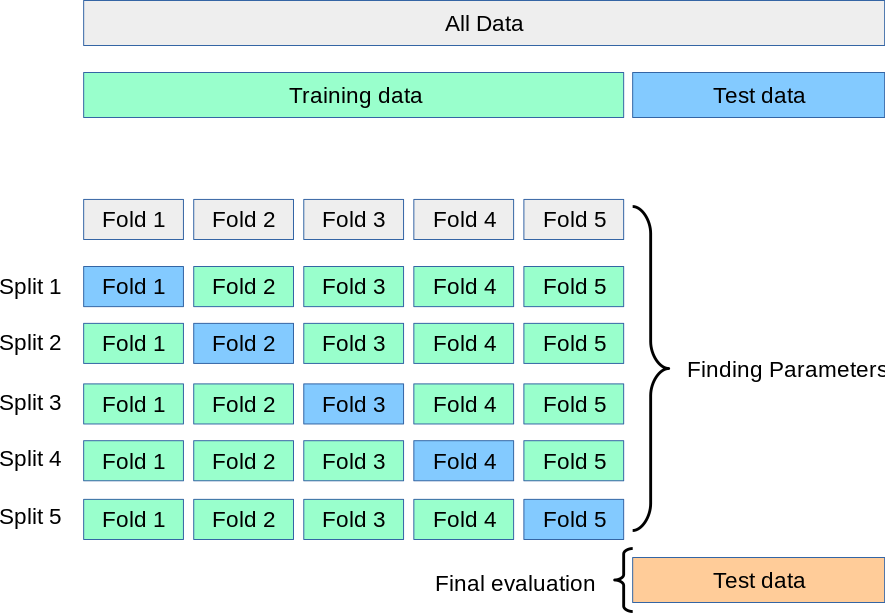

É um processo mais custoso em tempo do que a validação *holdout*, mas funciona muito bem para conjunto de dados pequenos, pois permite maior variedade no treinamento.

In [ ]:
# Crie uma instância do MLPClassifier
mlp = MLPClassifier(random_state=42)

# Crie uma instância do GridSearchCV com o classificador e a lista de hiperparâmetros
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)

# Treine o GridSearchCV no conjunto de treinamento
grid_search.fit(X_train, y_train)

# Obtenha a melhor configuração de hiperparâmetros
melhores_parametros = grid_search.best_params_

# Avalie o desempenho do modelo com a melhor configuração no conjunto de teste
melhor_modelo = grid_search.best_estimator_
y_pred = melhor_modelo.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)

print("Melhores hiperparâmetros encontrados:", melhores_parametros)
print("Acurácia do melhor modelo no conjunto de teste:", acuracia)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Melhores hiperparâmetros encontrados: {'activation': 'logistic', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
Acurácia do melhor modelo no conjunto de teste: 0.7951807228915663


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
melhores_parametros

{'activation': 'logistic',
 'alpha': 0.05,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'max_iter': 500,
 'solver': 'adam'}